In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

In [7]:
# генерация
n_samples = 300
random_centers = np.random.uniform(-3, 3, size=(2, 2))  # Случайные центры для генерации данных
cluster_std = [0.6, 0.6]

# Генерация данных вокруг случайных центров
data, _ = make_blobs(n_samples=n_samples, centers=random_centers, cluster_std=cluster_std, random_state=42)

In [8]:
# Инициализация параметров для EM
np.random.seed(42)
mu_init = np.random.uniform(-3, 3, size=(2, 2))  # Случайные начальные центры для EM
cov_init = [np.eye(2) * np.random.uniform(0.5, 1) for _ in range(2)]  
pi_init = np.array([0.5, 0.5])  # начальные веса 

In [9]:
# E-шаг
def e_step(data, mu, cov, pi):
    N = data.shape[0]
    K = len(mu)
    gamma = np.zeros((N, K)) 
    
    for k in range(K):
        gamma[:, k] = pi[k] * multivariate_normal.pdf(data, mean=mu[k], cov=cov[k])
    
    gamma /= gamma.sum(axis=1, keepdims=True)  # Нормализация
    return gamma

# M-шаг
def m_step(data, gamma):
    N, D = data.shape
    K = gamma.shape[1]
    
    Nk = gamma.sum(axis=0)
    mu = np.dot(gamma.T, data) / Nk[:, np.newaxis]
    cov = []
    
    for k in range(K):
        diff = data - mu[k]
        cov_k = np.dot(gamma[:, k] * diff.T, diff) / Nk[k] + np.eye(D) * 1e-6  
        cov.append(cov_k)
    
    pi = Nk / N
    return mu, cov, pi

# Визуализация
def plot_clusters(ax, data, gamma, mu, cov, iteration, initial=False):
    if initial:
        ax.scatter(data[:, 0], data[:, 1], c='green', s=20)  # Начальные точки 
    else:
        cluster_assignment = gamma[:, 0]  # Вероятности для первого кластера
        colors = np.array(['blue' if g > 0.5 else 'red' for g in cluster_assignment])
        ax.scatter(data[:, 0], data[:, 1], c=colors, s=20)  # Цветовая карта для точек
    
    for i, color in enumerate(['blue', 'red']):
        eigvals, eigvecs = np.linalg.eigh(cov[i])
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigvals)
        ell = plt.matplotlib.patches.Ellipse(xy=mu[i], width=width, height=height, angle=angle,
                                             edgecolor=color, facecolor='none', lw=2)
        ax.add_artist(ell)
    
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(f"Iteration {iteration}" if iteration > 0 else "Initial")

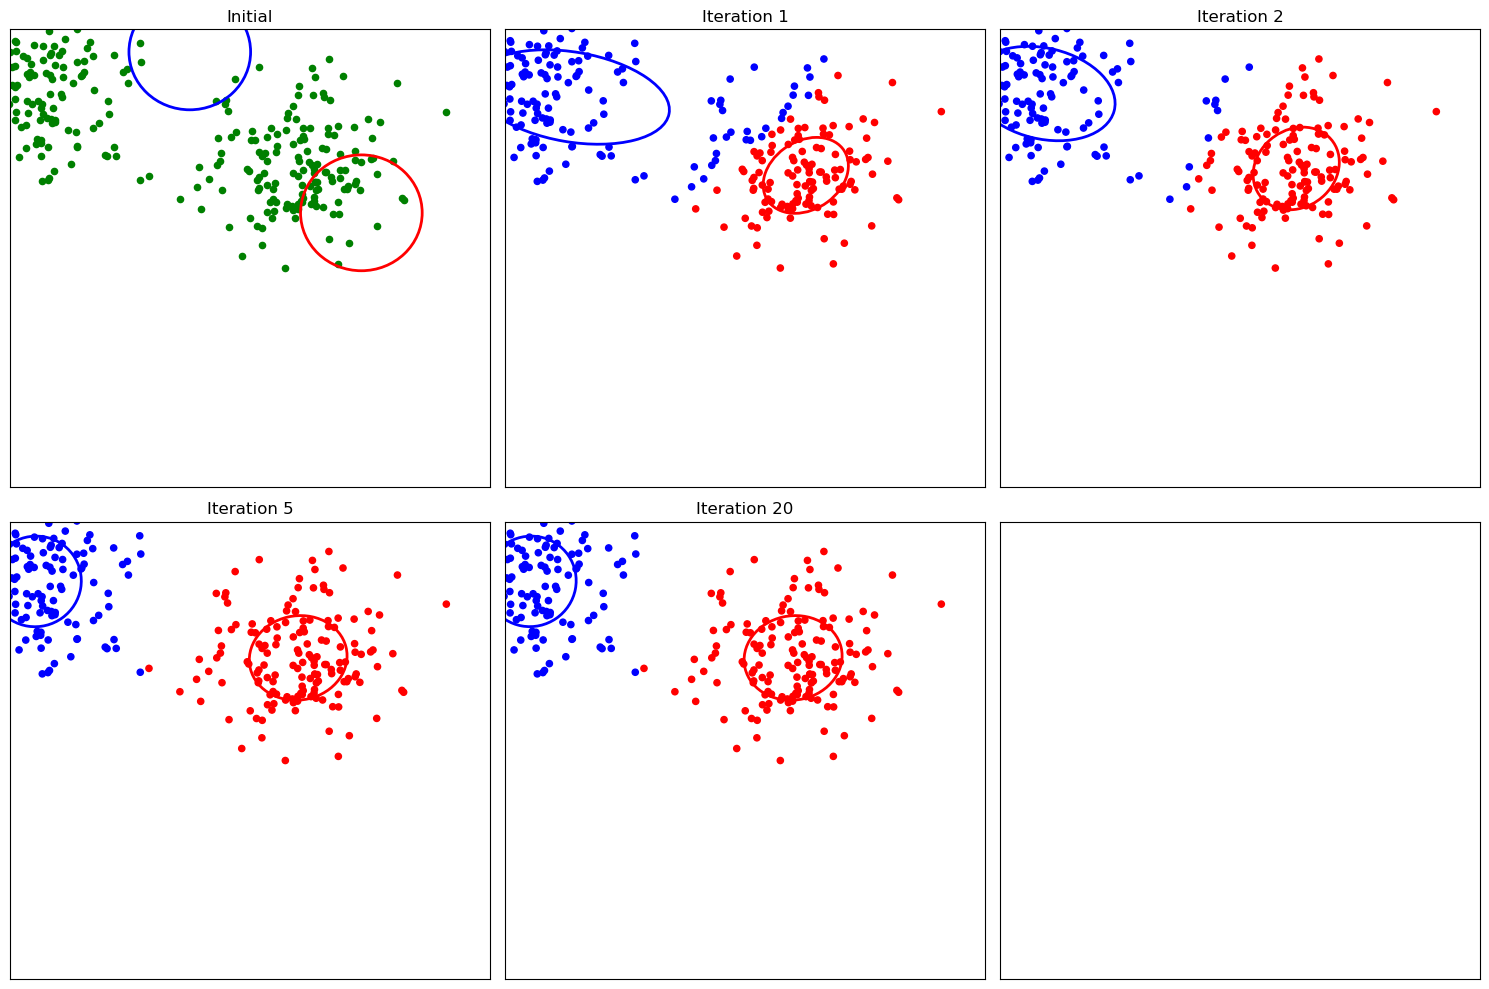

In [10]:
# Итерации EM-алгоритма
mu, cov, pi = mu_init, cov_init, pi_init

# Построение всех графиков на одном полотне
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Начальная визуализация (до применения алгоритма)
plot_clusters(axs[0, 0], data, np.full((n_samples, 2), 0.5), mu, cov, 0, initial=True)  # Начальная конфигурация

# Далее применяем EM-алгоритм и визуализируем на каждом шаге
iterations = [1, 2, 5, 20]
for i, it in enumerate(iterations):
    for _ in range(it):
        gamma = e_step(data, mu, cov, pi)
        mu, cov, pi = m_step(data, gamma)
    row, col = divmod(i+1, 3)  # Определяем место на сетке (всего 6 графиков, 2 строки и 3 столбца)
    plot_clusters(axs[row, col], data, gamma, mu, cov, it)

# Убираем оси для чистоты графиков
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()